## makemore: becoming a backprop ninja

In [ ]:
# there no change change in the first several cells from last lecture

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-05 13:24:54--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-07-05 13:24:54 (10.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ok biolerplate done, now we get to the action:

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n), useful for deriving a better estimate of a populations variance from a small sample (which Minibatches are). Using 1/n tends to underestimate the variance
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3159, grad_fn=<NegBackward0>)

In [ ]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------


#Tip 1: Gradient Dimensions must be the same as Data Dimensions

dlogprobs = torch.zeros(n,vocab_size) #Intuit. the logprobs not "plucked" out will have gradient of 0, as changing the values at the level of logprobs has no effect on the loss
dlogprobs[range(n), Yb] += -1.0/n
cmp('logprobs', dlogprobs, logprobs)

dprobs = (1.0/probs)*dlogprobs
cmp('probs', dprobs, probs)

# counts_sum_inv.shape is 32, 1 and counts shape is 32,27, thus counts_sum_inv is broadcasted/replicated; thus counts would be local derivative of dprobs/counts_sum_inv when counts_sum_inv is replicated. To account for broadcasting in this instance, we know counts_sum_inv (which has 32 elements), has each of these 32 elements basically used 27x times when multiplied by counts and as we know if a variable/node is used multiple times in a function, their total gradient is the sum of indiv. gradient

# dcounts_sum_inv = torch.unsqueeze(counts[range(n), Yb]*dprobs[range(n), Yb], dim = -1); I knew this from hand-deriving gradients, but below is a viable solution too

dcounts_sum_inv = (counts * dprobs).sum(1, keepdims = True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum = (-1*counts_sum**-2)*dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

# probs = counts * counts_sum_inv (where counts_sum_inv is in its broadcasted form)
# counts_sum[0] = counts[0][0] + counts[0][1] + ... + counts[0][27], derivative of counts_sum[0] w.r.t to any of these elements is 1
dcounts = counts_sum_inv*dprobs + torch.ones(counts.shape)*dcounts_sum
cmp('counts', dcounts, counts)

dnorm_logits = norm_logits.exp()*dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

# logits.shape is 32, 27 and logit_maxes is 32, 1, so each elements of logit_maxes are used 27x times in logits - logit_maxes (broadcasting once again), so sum the individual gradients for each element to compute the final value
dlogit_maxes = -1.0 * dnorm_logits.sum(1, keepdims = True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

# Remember we are only using logit_maxes for numerical stability, and if you remember, if you add or subtract values equally to all components of a tensor, the associated output probabilites will remain the same
# Thus, if logit_maxes does not change the probs, and therefore does not change the loss, then the gradient on logits_maxes should be 0. Because of floating point error, the values in the computer will be close but not equal to 0
# If we did want to compute dlogit_maxes/dlogits, we need to take dl/logit_maxes and scatter it to the correct position of the logits (i.e max values)

dlogits = 1*dnorm_logits
dlogit_maxes_dlogits = torch.zeros(logits.shape)
dlogit_maxes_dlogits[range(n), logits.max(1).indices] = 1
dlogits += dlogit_maxes_dlogits*dlogit_maxes

#Could also one one-hot instead of torch.zero

cmp('logits', dlogits, logits)

dh = dlogits @ W2.T #h = (32, 64), W2 = (64, 27), dlogits = (32, 27), b = (27) but is broadcasted to (32, 27), dlogits @ W2 = 32 64; use shapes to resolve
cmp('h', dh, h)

dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

db2 = dlogits.sum(dim = 0, keepdims = True)
cmp('b2', db2, b2)

dhpreact = (1.0 - (torch.tanh(hpreact)**2)) * dh
cmp('hpreact', dhpreact, hpreact)

#bngain is (1,64), bnbias is 1,64, and  bnraw is (32, 64), so bngain * bnraw uses a broadcasted/repeated version of bngain, where each of the 64 elements is 32x, and thus we sum the individual 32 gradients for eeach of the 64 elements to compute the total gradient for each element
dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
cmp('bngain', dbngain, bngain)

#Similiar to above, as bnbias is broadcasted
dbnbias = dhpreact.sum(0, keepdim = True)
cmp('bnbias', dbnbias, bnbias)

#we are using broadcasted version of bngain, as in the forward pass it is replicated the same way
dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

#bnvar_inv shape is (1,64), bndiff shape is (32, 64), and bnraw shape is (32, 64)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim = True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

#bnvar shape is 1,64
dbnvar = -0.5*((bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

#bndiff2 shape is 32,64, since forward pass added the elements column wise, as we know the backward pass of addition simply routes the gradients to the compontents of the forward sum, in this case elements from the same column get the same gradient
#Tip 2: Forward pass has sum, backward pass must have some broadcasting or replication in same dim
#Tip 3: Forward pass has broadcasting, backward pass must have sum in same dim

dbndiff2 = 1/(n-1)*torch.ones(bndiff2.shape)*dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

dbndiff = 2*bndiff*dbndiff2 + dbnraw * bnvar_inv
cmp('bndiff', dbndiff, bndiff)

#bndiff shape is (32, 64), hprebn shape is (32, 64), bnmeani shape (1, 64)
dbnmeani = -1*dbndiff.sum(0, keepdim = True)
cmp('bnmeani', dbnmeani, bnmeani)

dhprebn = dbndiff + torch.ones(hprebn.shape)* 1/n * dbnmeani
cmp('hprebn', dhprebn, hprebn)

dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

db1 = dhprebn.sum(0, keepdims = True)
cmp('b1', db1, b1)

demb = dembcat.view(emb.shape)
cmp('emb', demb, emb) #Derivative of view operation is view operation to original shape

#emb.shape is 32,3,10     C.shape is 27, 10,     Xb shape is 32,3
#We need to find which row of C, did each of these 10D embeddings come from, and deposit them into dC. If an embedding was used more then once, need to remember, indiv. gradients sum

dC = torch.zeros(C.shape)
for i, idx in enumerate(Xb):
  for j in range(len(idx)):
    dC[idx[j]] += demb[i].view(3, -1)[j]

cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

Tip 1: Gradient Dimensions must be the same as Data Dimensions

Tip 2: When needing to compress/reduce dimensions during gradient computation, summing is a good attmept

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3158581256866455 diff: 0.0


In [ ]:
# backward pass
#Doing this generates both a faster forward pass and backward pass
# -----------------
# YOUR CODE HERE :)
# TODO. my solution is 3 lines
print(logits.shape)

dlogits = (1/n)*F.softmax(logits, 1)
dlogits[range(n), Yb] += (-1/n)*1

print(dlogits.shape)
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

torch.Size([32, 27])
torch.Size([32, 27])
logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:

#NEEDED HELP, TRY AGAIN
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
dlogits[0]

tensor([ 0.0020,  0.0030,  0.0006,  0.0016,  0.0006,  0.0026,  0.0007,  0.0011,
        -0.0307,  0.0010,  0.0012,  0.0011,  0.0012,  0.0009,  0.0011,  0.0004,
         0.0003,  0.0006,  0.0005,  0.0016,  0.0015,  0.0007,  0.0008,  0.0022,
         0.0019,  0.0009,  0.0007], grad_fn=<SelectBackward0>)

In [ ]:
dlogits[0].sum()

tensor(-2.3283e-09, grad_fn=<SumBackward0>)

Will find that dlogits for a particular example will sum to 0, where incorrect classes have positive grad, which will reduce their values, and the correct class will have a negative grad, which will increase it value

The amount of "force" we are applying to update these logits, it proportional to the probs which came out in the forward pass. Where if our probs came out exactly correct, 1.0 at correct class and 0 elsewhere, the dlogits would be all a row of 0 for that example, no push and pull. However, if you have a confidently mispredicted example, that element will be pulled down very heavily, and the correct answer will be pulled up the same amount

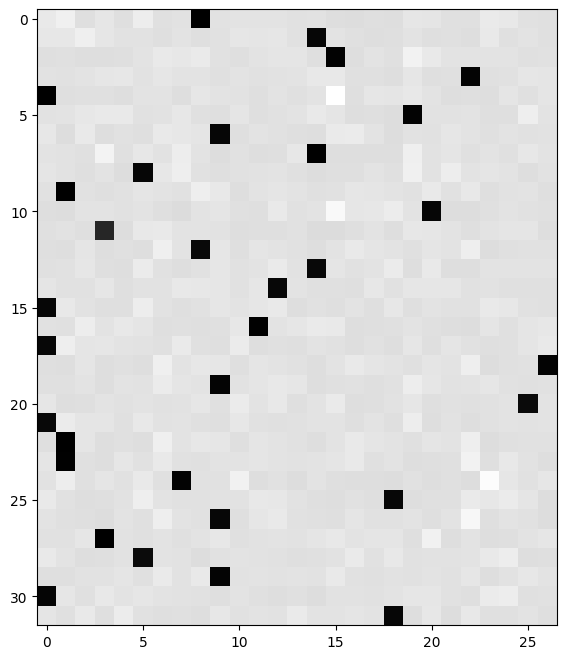

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(dlogits.detach(), cmap = "gray")

In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

#ignore gamma and beta

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
print(hprebn.shape)
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

torch.Size([32, 64])
hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
 # Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)

  dlogits = (1/n)*F.softmax(logits, 1)
  dlogits[range(n), Yb] += (-1/n)*1

  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(dim = 0, keepdims = True)
  dhpreact = (1.0 - (torch.tanh(hpreact)**2)) * dh

  dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
  dbnbias = dhpreact.sum(0, keepdim = True)
  dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0, keepdims = True)
  demb = dembcat.view(emb.shape)

  dC = torch.zeros(C.shape)
  for k, idx in enumerate(Xb):
    for j in range(len(idx)):
      dC[idx[j]] += demb[k].view(3, -1)[j]

  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    print(i)
    break

12297
      0/ 200000: 3.7863
100


In [ ]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))